When naming file saves:
1. USE TIME STAMPS
2. separate values using an underscore
3. in the same order, must include the following: size, validationloss, current epoch, total epoch, learning rate, batch size, time stamp
4. file name: Unet{downscale}x_VL_{VL}_CE_{CE}_TE_{TE}_LR_{list(lr)}_BS_{BS}_{TS}.pt
5. name = Unet{downscale}x_VL_{VL}_CE_{CE}_TE_{TE}_LR_{list(lr)}_BS_{BS}_{TS}

Notebook organization
1. import libraries
2. user function
3. user variables
4. executables

In [1]:
import unet
import image_processor
import torch
import os
import zipfile
from datetime import datetime
import torchvision
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
def modelWriter(model, path : str):
    torch.save(model.state_dict(), path)
    
#thanks chatGPT
def zip_file(file_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        zipf.write(file_path, arcname=os.path.basename(file_path))
    os.remove(file_path)


In [3]:

imageDir = r"C:\Users\myfir\My Drive\Segmentation_Files\Datasets\Rename_Data\train_val\Rename_TrainVal_Image"
labelDir = r"C:\Users\myfir\My Drive\Segmentation_Files\Datasets\Rename_Data\train_val\Rename_TrainVal_Label"
modelSaveDir = r"C:\Users\myfir\My Drive\Segmentation_Files\Models\Test"



#class name
baseModel = "unet"

#downscale
downscale = 16

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((int(256/downscale), int(1024/downscale)))])

batchSizes = [16]
epochs = [400]
learningRates = [.001, .0005]

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

saveDir= f'{modelSaveDir}/{baseModel}/'



EPOCHS: 400 | LR: 0.001 | BATCH: 16
EPOCH: 1 | 2024-04-12_18-54-50
EPOCH: 1 | TRAIN LOSS: 4619 | 2024-04-12_18-55-36
EPOCH: 1 | VAL LOSS: 4094 | 2024-04-12_18-55-36
C:\Users\myfir\My Drive\Segmentation_Files\Models\Test/unet/unet16x_VL_4094_CE_1_TE_400_LR_0.001_BS_16_TS_2024-04-12_18-55-36.pt saved


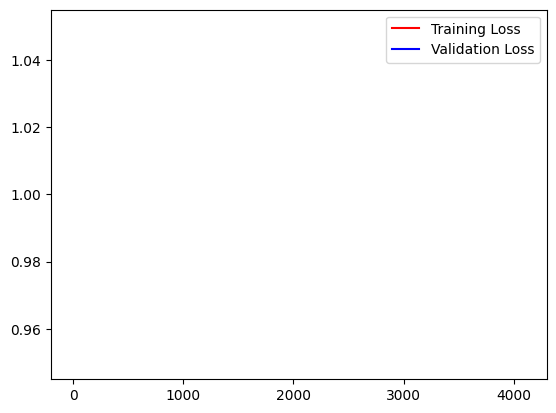

EPOCH: 2 | 2024-04-12_18-56-17


KeyboardInterrupt: 

In [4]:
for e in epochs:
    for lr in learningRates:
        for bs in batchSizes:
            model = unet.unet()
            model.to(device)

            trainLoader, valLoader = image_processor.imageDirsToLoaders(imageDir=imageDir, labelDir= labelDir, batchSize= bs, labelTransforms=transform, imageTransforms=transform)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            loss = torch.nn.MSELoss()

            print(f'EPOCHS: {e} | LR: {lr} | BATCH: {bs}')

            for i in range(e):
                #if (i+1) > 200:
                #    lr = .0001
                model.train()
                currentTime = datetime.now()
                formatTime = currentTime.strftime("%Y-%m-%d_%H-%M-%S")
                print(f'EPOCH: {i+1} | {formatTime}')
                runningLoss = 0
                trainingLoss = 0
                for image, label in trainLoader:
                    image = image.to(device)
                    label = label.to(device)
                    optimizer.zero_grad()
                    outputClasses = model(image)
                    
                    batchLoss = loss(outputClasses, label)
                    
                    batchLoss.backward()
                    optimizer.step()
                    trainingLoss += batchLoss

                currentTime = datetime.now()
                formatTime = currentTime.strftime("%Y-%m-%d_%H-%M-%S")
                trainingLoss = round(trainingLoss.item()/len(trainLoader))
                print(f"EPOCH: {i+1} | TRAIN LOSS: {trainingLoss} | {formatTime}")

                
                batchLoss = 0
                trainingLoss = 0
            
                validationLoss = 0

                model.eval()
                with torch.no_grad():
                    for image, label in valLoader:
                        image = image.to(device)
                        label = label.to(device)
                        outputs = model(image)
                        valBatchLoss = loss(outputs, label)
                        validationLoss += valBatchLoss
                
                validationLoss = round(validationLoss.item()/len(valLoader))
                model.validationLosses.append(validationLoss)
                model.trainingLosses.append(trainingLoss)

                print(f"EPOCH: {i+1} | VAL LOSS: {validationLoss} | {formatTime}")

                detailedName = f'{baseModel}{downscale}x_VL_{validationLoss}_CE_{i+1}_TE_{e}_LR_{lr}_BS_{bs}_TS_{formatTime}'
                model.name = detailedName
                if not os.path.exists(saveDir):
                    os.makedirs(saveDir)
                
                modelSavePath = os.path.join(saveDir, f'{detailedName}.pt')
                
                torch.save(
                        {
                        'model_state_dict': model.state_dict(),
                        'model_name': model.name,
                        'training_losses': model.trainingLosses,
                        'validation_losses': model.validationLosses
                    }
                        , modelSavePath )
                print(f'{modelSavePath} saved')
                epochsSoFar = list(j for j in range(1, i+2))
                plt.plot(epochsSoFar, model.trainingLosses,  label = 'Training Loss', color = 'red')
                plt.plot( epochsSoFar, model.validationLosses, label = 'Validation Loss', color = 'blue')
                plt.legend()
                plt.show()

                if (i+1) % 10 == 0:
                    clear_output(wait=True)

            
            


